In [ ]:
experiment = 'exp1'

# Single Experiment Analysis

## 1. Load Navigation Results

The navigation results can be found in the files named `K<>W<>D<>T<>` inside the experiments folder. They're formatted as

```
<k-mer>: <count> <out edges (in binary)>
```

For example:

```
AGACATGCATA: 15 0101
```

The first step here is to read the navigation result file from the given experiment and parse it into a dictionary of the form

```
{
    <k-mer>: {
        'count': <count>,
        'out_edges': <out edges (in binary)>
    }
}
```

In [25]:
navigated_kmers = {}
with open(f'{experiment}/K16W3680000D8T1') as navigation_file:
    for line in navigation_file:
        kmer, query_result = line.strip().split(':')
        count, out_edges = query_result.strip().split(' ')
        count = int(count)
        out_edges = int(out_edges, 2)
        navigated_kmers[kmer] = {
            'count': count,
            'out_edges': out_edges
        }

## 2. Count the real k-mers in the reads file

The next step is to go through all the reads in the reads file and count the number of times each k-mer appears.

In [26]:
kmer_counts_reads = {}
with open(experiment + '/reads.txt', 'r') as reads_file:
    for k in ks:
        kmer_counts_reads[k] = {}
        for line in reads_file:
            for i in range(len(line) - k):
                kmer = line[i:i+k]
                if kmer not in kmer_counts_reads[k]:
                    kmer_counts_reads[k][kmer] = 0
                kmer_counts_reads[k][kmer] += 1

## 3. Results Summary

The results from the experiment are compared to the real k-mers.

The real number of distinct k-mers is printed, followed by the number of distinct k-mers that were visited during the graph traversal, and the number of k-mers that were found to be present in the graph.

Then the number of false negatives is printed. A false negative is a k-mer that is found in the reads but was not found to be present in the graph. A false negative rate is also printed, defined as proportion of real k-mers that were not found in the graph (i.e.: # false negatives / # real k-mers).

Finally, the number of false positives is printed. A false positive is a k-mer that is considered to be in the graph that, however, is not found in the reads. A false positive rate is printed, defined as the proportion of k-mers that were found in the graph but not in the reads (i.e.: # false positives / # k-mers in the graph).

In [36]:
print(f'Total k-mers in reads: {len(kmer_counts_reads[16])}')

print(f'Total Visited k-mers: {len(navigated_kmers)}')

found_kmers = set(kmer for kmer in navigated_kmers if navigated_kmers[kmer]['count'] >= 1)
print(f'Found k-mers: {len(found_kmers)}')

false_negatives = set(kmer for kmer in kmer_counts_reads[16] if kmer not in found_kmers)
print(f'False Negatives (Count): {len(false_negatives)}')
print(f'False Negatives (Rate): {100*len(false_negatives) / len(kmer_counts_reads[16])}%')

false_positives = set(kmer for kmer in found_kmers if kmer not in kmer_counts_reads[16])
print(f'False Positives (Count): {len(false_positives)}')
print(f'False Positives (Rate): {100*len(false_positives) / len(found_kmers)}%')


Total k-mers in reads: 4544542
Total Visited k-mers: 4630589
Found k-mers: 4550152
False Negatives (Count): 0
False Negatives (Rate): 0.0%
False Positives (Count): 5610
False Positives (Rate): 0.12329258451146248%


# Bulk Analysis

## 1. Load Navigation Results for All Experiments

All the experiment files are read and parsed, with the results being stored in a list of dictionaries of the form

```
[
    {
        'k': k,
        'W': W,
        'D': D,
        'presence_threshold': presence_threshold,
        'navigation_results': {
            <k-mer>: (<count>, <out edges>)
        }
    },
    ...
]
```

In [12]:
import os
import re

experiment = 'exp1'

result_file_name_format = re.compile(r'K(\d+)W(\d+)D(\d+)T(\d+)')
result_files = list(filter(lambda file_name: result_file_name_format.match(file_name), os.listdir(experiment)))

def process_results_file(file_name):
    navigation_results = {}
    with open(f'{experiment}/{file_name}', 'r') as results_file:
        for line in results_file:
            kmer, query_result = line.strip().split(": ")
            count, out_edges = query_result.strip().split(" ")
            navigation_results[kmer] = (int(count), int(out_edges, 2))
    
    return navigation_results

ks = set()
results = []
for file in result_files:
    filename_re_match = result_file_name_format.match(file)
    k = int(filename_re_match.group(1))
    ks.add(k)
    W = int(filename_re_match.group(2))
    D = int(filename_re_match.group(3))
    presence_threshold = int(result_file_name_format.match(file).group(4))
    print(file)
    navigation_results = process_results_file(file)
    results.append({
        "k": k,
        "W": W,
        "D": D,
        "presence_threshold": presence_threshold,
        "navigation_results": navigation_results
    })

K16W1856660D8T1
K16W4177485D16T1
K16W2784990D16T1
K16W4177485D8T1
K16W1856660D16T1
K16W2320825D8T1
K16W3713320D16T1
K16W3713320D8T1
K16W2784990D8T1
K16W3249155D8T1
K16W2320825D16T1
K16W3249155D16T1


In [13]:
for result in results:
    visited_kmers = set(result['navigation_results'])
    actual_kmers = set(kmer_counts_reads[result['k']])
    found_kmers = set(filter(lambda kmer: result['navigation_results'][kmer][0] > result['presence_threshold'], visited_kmers))
    false_positives = found_kmers - actual_kmers
    false_negatives = actual_kmers - found_kmers
    result['visited_count'] = len(visited_kmers)
    result['found_count'] = len(found_kmers)
    result['false_positives'] = false_positives
    result['false_negatives'] = false_negatives
    result['false_positive_count'] = len(false_positives)
    result['false_negative_count'] = len(false_negatives)
    result['false_positive_rate'] = len(false_positives) / len(found_kmers)
    result['false_negative_rate'] = len(false_negatives) / len(actual_kmers)

In [14]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.head()

,k,W,D,presence_threshold,navigation_results,visited_count,found_count,false_positives,false_negatives,false_positive_count,false_negative_count,false_positive_rate,false_negative_rate
0,16,1856660,8,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",7281097,5880279,"{GCATCGCTTCAGTTTT, TGATCGAAGGCGTTTT, TACATTCCC...","{GACAAAAAACCTTTAT, CTTTTCATTCTGACTG, TTAGTAAGT...",1335743,6,0.227156,0.000001
1,16,4177485,16,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",4544936,4544537,{},"{TTAGTAAGTATTTTTC, CTTTTCATTCTGACTG, CTTAGTAAG...",0,5,0.000000,0.000001
2,16,2784990,16,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",4562203,4545094,"{TATGCAAAAACAAGCT, GAATTTTTACTGCTAT, CAGGATACC...","{TTAGTAAGTATTTTTC, CTTTTCATTCTGACTG, CTTAGTAAG...",557,5,0.000123,0.000001
3,16,4177485,8,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",4589225,4546316,"{CAACTCAAAGACCAAT, ACGCTTTCCAGTGGGT, GGCATGATA...","{TTAGTAAGTATTTTTC, CTTTTCATTCTGACTG, CTTAGTAAG...",1779,5,0.000391,0.000001
4,16,1856660,16,1,"{'GTTATGATACGTTTCG': (84, 4), 'CGCAACGTCAATACG...",4919699,4633596,"{GGTCGGAGGTTCAAAG, GGCGTCGAGAGTATCG, TATTTACGC...","{TTAGTAAGTATTTTTC, CTTTTCATTCTGACTG, CTTAGTAAG...",89059,5,0.019220,0.000001


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
mpl.style.use('seaborn')

In [16]:
filtered_df = results_df.loc[results_df['presence_threshold'] == 1]
filtered_df = filtered_df.sort_values(['D', 'W'])

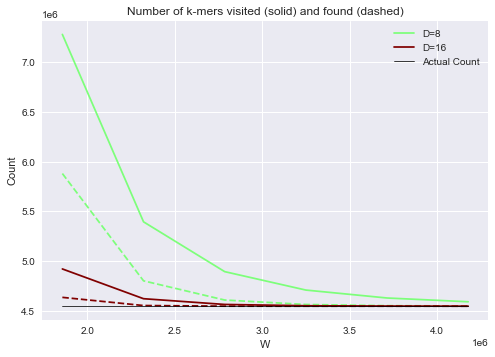

In [17]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

for D, group in filtered_df.groupby('D'):
    plt.plot(group['W'], group['visited_count'], label=f'D={D}', color=colors[D])
    plt.plot(group['W'], group['found_count'], '--', color=colors[D])

plt.plot([filtered_df['W'].min(), filtered_df['W'].max()], [len(kmer_counts_reads[filtered_df['k'].min()]), len(kmer_counts_reads[filtered_df['k'].min()])], color='black', label='Actual Count', linewidth=0.75)
plt.legend()
plt.xlabel('W')
plt.ylabel('Count')
plt.title('Number of k-mers visited (solid) and found (dashed)')
plt.show()

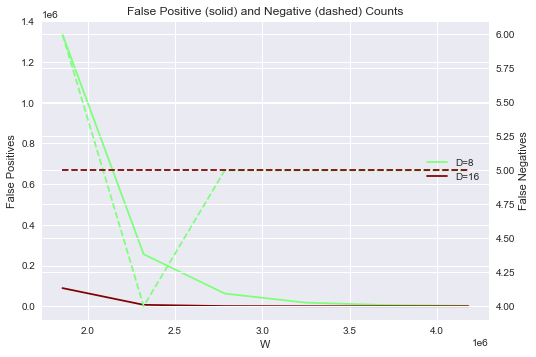

In [18]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby('D'):
    ax1.plot(group['W'], group['false_positive_count'], label=f'D={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_count'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Counts')
plt.show()

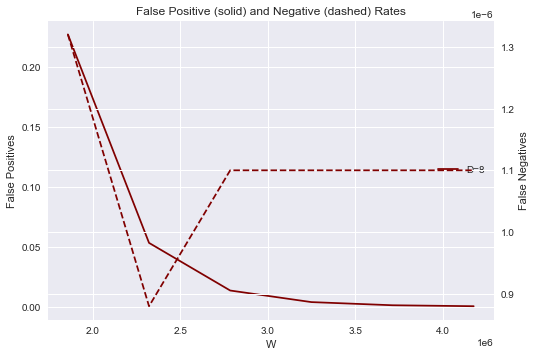

In [11]:
colors = cm.jet(np.linspace(0, 1, filtered_df['D'].max()+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for D, group in filtered_df.groupby('D'):
    ax1.plot(group['W'], group['false_positive_rate'], label=f'D={D}', color=colors[D])
    ax2.plot(group['W'], group['false_negative_rate'], '--', color=colors[D])
ax1.legend(loc='right')
ax1.set_xlabel('W')
ax1.set_ylabel('False Positives')
ax2.set_ylabel('False Negatives')
plt.title('False Positive (solid) and Negative (dashed) Rates')
plt.show()

In [23]:
filtered_df[(filtered_df['W'] == 4177485) & (filtered_df['D'] == 16)]['false_negatives'].to_list()[0]

{'CCTTAGTAAGTATTTT',
 'CTTAGTAAGTATTTTT',
 'CTTTTCATTCTGACTG',
 'GCTTTTCATTCTGACT',
 'TTAGTAAGTATTTTTC'}